<a href="https://colab.research.google.com/github/Robin-01/California-Coastal-Sea-Currents/blob/main/wind_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install herbie-data


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.5/113.5 kB 1.5 MB/s eta 0:00:00


In [18]:
from herbie import Herbie
import xarray as xr
import numpy as np

# HRRR run: Jan 1, 2024, 00 UTC, 0-hr forecast
H = Herbie(
    "2024-01-01 00:00",
    model="hrrr",
    product="sfc",
    fxx=0
)
H.inventory()


✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Jan-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


,grib_message,start_byte,end_byte,range,reference_time,valid_time,variable,level,forecast_time,search_this
0,1,0,202809.0,0-202809,2024-01-01,2024-01-01,REFC,entire atmosphere,anl,:REFC:entire atmosphere:anl
1,2,202810,246792.0,202810-246792,2024-01-01,2024-01-01,RETOP,cloud top,anl,:RETOP:cloud top:anl
2,3,246793,496145.0,246793-496145,2024-01-01,2024-01-01,var discipline=0 center=7 local_table=1 parmca...,entire atmosphere,anl,:var discipline=0 center=7 local_table=1 parmc...
3,4,496146,649032.0,496146-649032,2024-01-01,2024-01-01,VIL,entire atmosphere,anl,:VIL:entire atmosphere:anl
4,5,649033,2038336.0,649033-2038336,2024-01-01,2024-01-01,VIS,surface,anl,:VIS:surface:anl
...,...,...,...,...,...,...,...,...,...,...
165,166,126776108,126785469.0,126776108-126785469,2024-01-01,2024-01-01,ICEC,surface,anl,:ICEC:surface:anl
166,167,126785470,128189723.0,126785470-128189723,2024-01-01,2024-01-01,SBT123,top of atmosphere,anl,:SBT123:top of atmosphere:anl
167,168,128189724,130514441.0,128189724-130514441,2024-01-01,2024-01-01,SBT124,top of atmosphere,anl,:SBT124:top of atmosphere:anl
168,169,130514442,131785130.0,130514442-131785130,2024-01-01,2024-01-01,SBT113,top of atmosphere,anl,:SBT113:top of atmosphere:anl


In [47]:

from herbie import Herbie
import xarray as xr
import numpy as np

def load_hrrr_dataset(time_str, fxx=0):
    """
    Load HRRR 10m wind dataset for a given run time.

    Parameters:
        time_str (str): HRRR run time, e.g., "2024-01-01 00:00"
        fxx (int): Forecast hour offset (default 0)

    Returns:
        xarray.Dataset: merged dataset containing u10 and v10
    """
    H = Herbie(time_str, model="hrrr", product="sfc", fxx=fxx)

    ds_u_list = H.xarray(":UGRD:10 m above ground:anl")
    ds_v_list = H.xarray(":VGRD:10 m above ground:anl")

    ds_u = ds_u_list['u10']
    ds_v = ds_v_list['v10']

    ds = xr.merge([ds_u, ds_v])
    return ds

def get_wind_at_buoy(ds, lat_buoy, lon_buoy):
    """
    Extract U10, V10, and wind speed at a given buoy location from HRRR dataset.

    Parameters:
        ds (xarray.Dataset): HRRR dataset
        lat_buoy (float): buoy latitude
        lon_buoy (float): buoy longitude

    Returns:
        dict: {'u10': ..., 'v10': ..., 'wind_speed': ...}
    """
    lat2d = ds['latitude'].values
    lon2d = ds['longitude'].values

    distance = np.sqrt((lat2d - lat_buoy)**2 + (lon2d - lon_buoy)**2)
    iy, ix = np.unravel_index(np.argmin(distance), distance.shape)

    u10_val = ds['u10'].values[iy, ix]
    v10_val = ds['v10'].values[iy, ix]
    wind_speed = np.sqrt(u10_val**2 + v10_val**2)

    return {'u10': u10_val, 'v10': v10_val, 'wind_speed': wind_speed}




In [65]:
import pandas as pd
from herbie import Herbie
import xarray as xr
import numpy as np

# Define buoy coordinates (12 buoys offshore CA)
buoys = {
    "1": (42.0, -125.5),
    "2": (41.0, -125.0),
    "3": (39.8, -124.7),
    "4": (38.5, -124.0),
    "5": (37.5, -123.5),
    "6": (36.5, -123.0),
    "7": (35.5, -122.0),
    "8": (34.5, -121.5),
    "9": (33.3, -120.5),
    "10": (32.7, -119.5),
    "11": (32.0, -118.5),
    "12": (31.5, -117.5),
}



# Define HRRR run times (for demo, just a few times; you can expand)
times = ["2024-01-01 8:00", "2024-03-01 08:00", "2024-05-01 8:00", "2024-07-01 8:00", "2024-09-01 8:00", "2024-11-01 8:00"]
#times = pd.date_range("2024-01-01 00:00", "2025-08-18 23:00", freq="H").strftime("%Y-%m-%d %H:%M").tolist()

# Store results
all_data = []


for time_str in times:
    ds = load_hrrr_dataset(time_str)
    for buoy_id, (lat, lon) in buoys.items():
        try:
            wind = get_wind_at_buoy(ds, lat, lon)
            all_data.append({
                "time": time_str,
                "buoy": buoy_id,
                "lat": lat,
                "lon": lon,
                "u10": wind['u10'],
                "v10": wind['v10'],
                "wind_speed": wind['wind_speed']
            })
        except Exception as e:
            print(f"Error for buoy {buoy_id} at {time_str}: {e}")

# Convert to DataFrame
df_wind = pd.DataFrame(all_data)
print(df_wind)


✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Jan-01 08:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Mar-01 08:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-May-01 08:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Jul-01 08:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Sep-01 08:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Nov-01 08:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
               time buoy   lat    lon       u10       v10  wind_speed
0   2024-01-01 8:00    1  42.0 -125.5 -1.808705  9.610407    9.779127
1   2024-01-01 8:00    2  41.0 -125.0 -1.808705  9.610407    9.779127
2   2024-01-01 8:00    3  39.8 -124.7 -1.808705  9.610407    9.779127
3   2024-01-01 8:00    4  38.5 -124.0 -1.808705  9.610407    9.779127
4   2024-01-01 8:00    5  37.5 -123.5 -1.808705  9.610407    9.779127
..              ...  ...   ...    ...       ..

In [41]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 32.8 MB/s eta 0:00:00


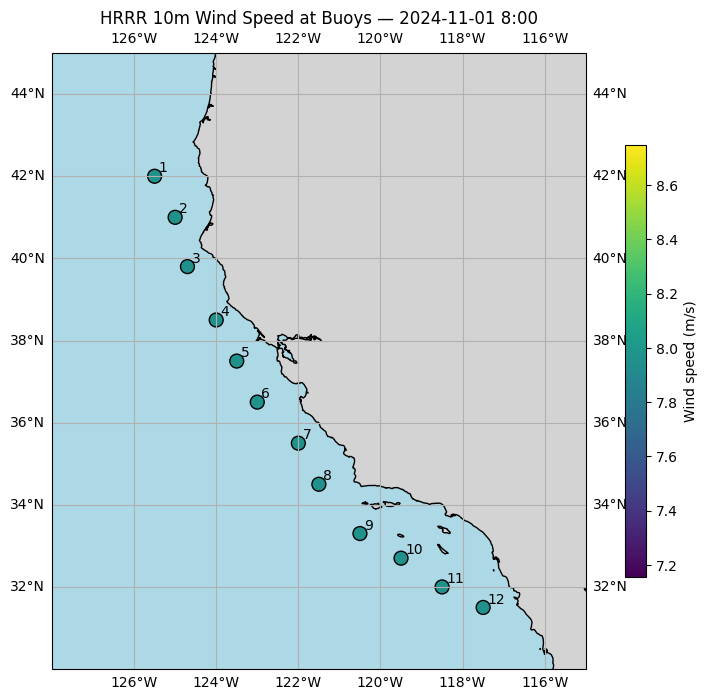

In [66]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Latest wind data for each buoy (or choose a specific time)
latest_time = df_wind['time'].max()
df_plot = df_wind[df_wind['time'] == latest_time]

# Create a map
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -115, 30, 45], crs=ccrs.PlateCarree())  # CA offshore

# Add coastlines and features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.gridlines(draw_labels=True)

# Scatter plot of buoy winds
sc = ax.scatter(
    df_plot['lon'], df_plot['lat'],
    c=df_plot['wind_speed'],
    cmap='viridis',
    s=100,
    edgecolor='k',
    transform=ccrs.PlateCarree()
)

# Add colorbar
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', shrink=0.7)
cbar.set_label("Wind speed (m/s)")

# Add buoy IDs as labels
for idx, row in df_plot.iterrows():
    ax.text(row['lon']+0.1, row['lat']+0.1, row['buoy'], transform=ccrs.PlateCarree())

plt.title(f"HRRR 10m Wind Speed at Buoys — {latest_time}")
plt.show()


/tmp/ipython-input-3345721825.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', 12)  # 12 discrete colors for months


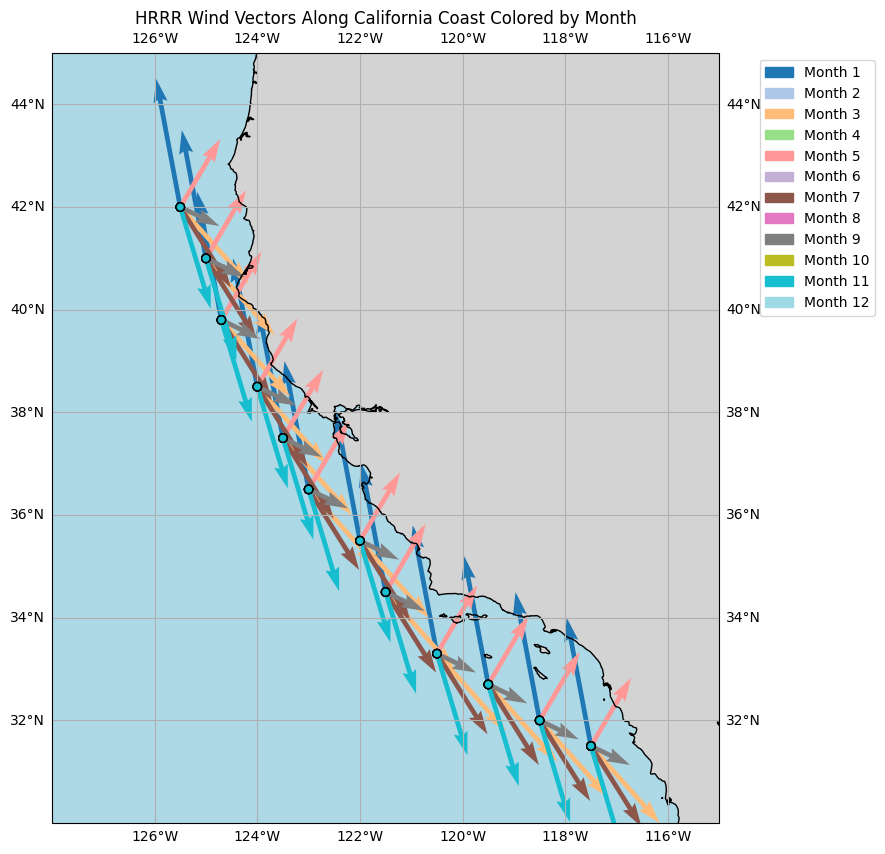

In [85]:
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

# Convert 'time' column to datetime if not already
df_wind['time'] = pd.to_datetime(df_wind['time'])

# Extract month for each row
df_wind['month'] = df_wind['time'].dt.month

# Extract arrays for plotting
lats = df_wind['lat'].values
lons = df_wind['lon'].values
u10 = df_wind['u10'].values
v10 = df_wind['v10'].values
months = df_wind['month'].values

# Use a colormap
cmap = plt.cm.get_cmap('tab20', 12)  # 12 discrete colors for months
colors = cmap(months - 1)  # months 1-12 → indices 0-11

# Create Cartopy figure
fig = plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -115, 30, 45], crs=ccrs.PlateCarree())  # CA offshore

# Add map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Plot wind vectors
quiver = ax.quiver(lons, lats, u10, v10, color=colors, scale=50)

# Plot buoy positions
ax.scatter(lons, lats, color=colors, edgecolor='k', zorder=5)

# Create a legend for months
patches = [mpatches.Patch(color=cmap(i), label=f'Month {i+1}') for i in range(12)]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('HRRR Wind Vectors Along California Coast Colored by Month')
plt.show()
